# **Unsupervised chunking in Indian languages**

---

Sumit Bhuin (2019201034)
Virat Mishra (2019201033)

## Downloading Dataset

In [2]:
!wget "https://raw.githubusercontent.com/vm-iiit/Unsupervised-chunking-in-Indian-languages/master/Datasets/Unprocessed_data/Data4" -O Data

--2021-04-27 05:24:10--  https://raw.githubusercontent.com/vm-iiit/Unsupervised-chunking-in-Indian-languages/master/Datasets/Unprocessed_data/Data4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173421 (169K) [text/plain]
Saving to: ‘Data’

Data                100%[===================>] 169.36K  --.-KB/s    in 0.02s   

2021-04-27 05:24:10 (10.0 MB/s) - ‘Data’ saved [173421/173421]



## Installing various word embedding models

In [115]:
!pip install fasttext -q
import fasttext
import fasttext.util

In [4]:
!wget "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.bin.gz"

--2021-04-27 05:24:53--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4371554972 (4.1G) [application/octet-stream]
Saving to: ‘cc.hi.300.bin.gz’

cc.hi.300.bin.gz    100%[===================>]   4.07G  41.4MB/s    in 2m 1s   

2021-04-27 05:26:55 (34.4 MB/s) - ‘cc.hi.300.bin.gz’ saved [4371554972/4371554972]



In [5]:
!gzip -d "./cc.hi.300.bin.gz"

In [6]:
!pip install -U sentence-transformers -q

     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 2.1MB 12.0MB/s 
     |████████████████████████████████| 1.2MB 50.6MB/s 
     |████████████████████████████████| 3.3MB 57.9MB/s 
     |████████████████████████████████| 901kB 56.7MB/s 


In [7]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = TFBertModel.from_pretrained("bert-base-multilingual-cased")

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Importing prerequisite and installed library functions

In [8]:
import re
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import scipy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Bidirectional, LSTM, RepeatVector, Dense
from keras import Model, optimizers
from termcolor import colored
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering, ward_tree

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

## Function to print chunked sentences

In [9]:
def print_chunked_sentences(sentences, chunk_labels, count):

    colors = [
            "red",
            "green",
            "yellow",
            "blue",
            "magenta",
            "cyan",
    ]

    np.random.shuffle(colors)

    offset = np.random.randint(low=0, high = len(colors))

    for index in range(len(sentences[:count])):
        for ind in range(len(sentences[index])):
            print(colored(sentences[index][ind], colors[(chunk_labels[index][ind] + offset) % len(colors)], attrs=['bold']), end=' ')
        print('\n----------------------------------------')

## K means clustering

In [10]:
def k_means_clustering(sentences, cluster_count):
    chunk_labels = []
    kmeans = KMeans(n_clusters=cluster_count, random_state=0, init='random')
    for inp_vec in one_hot_enc_pos_input:
        chunk_labels.append(kmeans.fit_predict(inp_vec))

    return chunk_labels

## DBscan clustering

In [11]:
def DBscan_clustering(sentences, eps =.5, min_samples = 5):
    chunk_labels = []
    dbs = DBSCAN(eps=eps, min_samples=min_samples)
    for inp_vec in sentences:
        chunk_labels.append(dbs.fit_predict(inp_vec))

    return chunk_labels

## Agglomerative clustering

In [12]:
def agglomerative_clustering(sentences, cluster_count):
    chunk_labels = []
    amcs = AgglomerativeClustering(n_clusters=cluster_count)
    for inp_vec in sentences:
        chunk_labels.append(amcs.fit_predict(inp_vec))
    
    return chunk_labels

Ward Tree

In [13]:
def ward_tree_clustering(sentences):
    chunk_labels = []
    wt = ward_tree()
    for inp_vec in sentences:
        chunk_labels.append(wt.fit_predict(inp_vec))
    
    return chunk_labels

## Global variables

In [14]:
sentences = []
tags = []
all_tags = []
no_pos_tag = re.compile("(_ |_$)")
output_display_count = 10
cluster_count = 5

## Data parsing

In [15]:
with open("./Data", 'r') as inp_handler:
    
    lines = inp_handler.readlines()

    for index in range(len(lines)):
        if lines[index][0] == '<':
            continue
        else:
            # print(lines[index])
            sentence_list = []
            tag_list = []
            if re.search(no_pos_tag, lines[index]):
                continue
            else:
                if len(lines[index].split()) < cluster_count:
                    continue
                for pair in lines[index].split():
                    w, p = pair.split('_')
                    if not p:
                        print(lines[index])
                        break
                    sentence_list.append(w)
                    tag_list.append(p)
        sentences.append(sentence_list)
        tags.append(tag_list)
        all_tags.extend(tag_list)

## Unique POS tags of dataset

In [16]:
unique_pos_tags = set()
for tag_list in tags:
    for tag in tag_list:
        if tag and tag[0] != '<':
            unique_pos_tags.add(tag)
print(unique_pos_tags)
unique_pos_tags_array = np.array(list(unique_pos_tags))
unique_tag_count = len(unique_pos_tags_array)

{'JJ', 'PUNC', 'NLOC', 'SYM', 'VAUX', 'NVB', 'VJJ', 'NN', 'VNN', 'NNPC', 'NNC', 'RP', 'VFM', 'QW', 'PREP', 'VRB', 'QF', 'PRP', 'INTF', 'CC', 'NNP', 'QFNUM', 'NEG', 'RB', 'JVB'}


## POS tags only

In [105]:
enc = OneHotEncoder(sparse = False)
enc.fit(unique_pos_tags_array.reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [106]:
one_hot_enc_pos_input = []
for sentence_tag in tags:
    one_hot_enc_pos_input.append(np.array(enc.transform(np.array(sentence_tag).reshape(-1, 1))))

In [107]:
cluster_count = 3

### K means

In [116]:
chunked_sentence_labels = k_means_clustering(one_hot_enc_pos_input, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [109]:
chunked_sentence_labels = DBscan_clustering(one_hot_enc_pos_input)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [110]:
chunked_sentence_labels = agglomerative_clustering(one_hot_enc_pos_input, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

## POS tags + position

In [111]:
position_pos = []
for index in range(len(one_hot_enc_pos_input)):
    position_array = np.array([i for i in range(one_hot_enc_pos_input[index].shape[0])]).reshape((-1,1))
    position_pos.append(np.hstack((position_array, one_hot_enc_pos_input[index])))


### K means

In [112]:
chunked_sentence_labels = k_means_clustering(position_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [113]:
chunked_sentence_labels = DBscan_clustering(position_pos)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [114]:
chunked_sentence_labels = agglomerative_clustering(position_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

## Fastext Word embeddings

In [21]:
ft = fasttext.load_model('./cc.hi.300.bin')
ft.get_dimension()

300

In [92]:
fasttext_vectors = []
for s in sentences:
    word_vectors = []
    for word in s:
        word_vectors.append(ft.get_word_vector(word))
    fasttext_vectors.append(np.array(word_vectors))
# sentence_vectors[1].shape

### K means

In [93]:
chunked_sentence_labels = k_means_clustering(fasttext_vectors, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [94]:
chunked_sentence_labels = DBscan_clustering(fasttext_vectors)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [95]:
chunked_sentence_labels = agglomerative_clustering(fasttext_vectors, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

## POS tags + Fastext Word embeddings

In [96]:
fasttext_pos_vectors = []
for index in range(len(fasttext_vectors)):
    fasttext_pos_vectors.append(np.hstack((fasttext_vectors[index], np.array(one_hot_enc_pos_input[index]))))

### K means

In [97]:
chunked_sentence_labels = k_means_clustering(fasttext_pos_vectors, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [98]:
chunked_sentence_labels = DBscan_clustering(fasttext_pos_vectors)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [99]:
chunked_sentence_labels = agglomerative_clustering(fasttext_pos_vectors, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

## Position + Fasttext + POS

In [100]:
position_fasttext_pos = []
for index in range(len(fasttext_pos_vectors)):
    position_array = np.array([i for i in range(fasttext_pos_vectors[index].shape[0])]).reshape((-1,1))
    position_fasttext_pos.append(np.hstack((position_array, fasttext_pos_vectors[index])))


### K means

In [101]:
chunked_sentence_labels = k_means_clustering(position_fasttext_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [102]:
chunked_sentence_labels = DBscan_clustering(position_fasttext_pos)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [104]:
chunked_sentence_labels = agglomerative_clustering(position_fasttext_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

## BERT pretrained emebeddings

In [51]:
bert_encoded_input = []
i = 0
for s in sentences:
    print(i,end='')
    sentence_matrix = []
    for word in s:
        text = word
        encoded_input = tokenizer(text, return_tensors='tf')
        output = model(encoded_input)
        encoded_word = np.mean(output[0][0], axis=0)
        sentence_matrix.append(encoded_word)
    bert_encoded_input.append(np.array(sentence_matrix))
    print("\r",end='')
    i+=1


### K means

In [55]:
chunked_sentence_labels = k_means_clustering(bert_encoded_input, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [56]:
chunked_sentence_labels = DBscan_clustering(bert_encoded_input)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [57]:
chunked_sentence_labels = agglomerative_clustering(bert_encoded_input, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

## POS tags + BERT embeddings

In [60]:
bert_encoded_with_pos = []
for index in range(len(bert_encoded_input)):
    bert_encoded_with_pos.append(np.hstack((bert_encoded_input[index], np.array(one_hot_enc_pos_input[index]))))

### K means

In [61]:
chunked_sentence_labels = k_means_clustering(bert_encoded_with_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [62]:
chunked_sentence_labels = DBscan_clustering(bert_encoded_with_pos)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [63]:
chunked_sentence_labels = agglomerative_clustering(bert_encoded_with_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

## Position + BERT + POS

In [87]:
position_bert_pos = []
for index in range(len(bert_encoded_with_pos)):
    position_array = np.array([i for i in range(bert_encoded_with_pos[index].shape[0])]).reshape((-1,1))
    position_bert_pos.append(np.hstack((position_array, bert_encoded_with_pos[index])))


### K means

In [89]:
chunked_sentence_labels = k_means_clustering(position_bert_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [90]:
chunked_sentence_labels = DBscan_clustering(position_bert_pos)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [91]:
chunked_sentence_labels = agglomerative_clustering(position_bert_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

## Autoencoder

In [64]:
maxlen = 0
embed_dim = 150
num_words = 50000
for sent in sentences:
    maxlen = max(maxlen, len(sent))
maxlen

55

In [65]:
tokenizer = Tokenizer(num_words = num_words, split=' ')
tokenizer.fit_on_texts(sentences)
seqs = tokenizer.texts_to_sequences(sentences)
pad_seqs = pad_sequences(seqs, maxlen)

In [66]:
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False)
x = emb_layer(encoder_inputs)
state_h = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM'))(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

decoded = RepeatVector(maxlen)(seq2seq_encoder_out)
decoder_lstm = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm_output = decoder_lstm(decoded)
decoder_dense = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs = decoder_dense(decoder_lstm_output)

seq2seq_Model = Model(encoder_inputs, decoder_outputs)
seq2seq_Model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
history = seq2seq_Model.fit(pad_seqs, np.expand_dims(pad_seqs, -1),
            batch_size=100,
            epochs=30)

Epoch 1/30
5/5 [==============================] - 33s 307ms/step - loss: 10.8087
Epoch 2/30
5/5 [==============================] - 1s 287ms/step - loss: 10.5811
Epoch 3/30
5/5 [==============================] - 1s 280ms/step - loss: 9.2595
Epoch 4/30
5/5 [==============================] - 1s 299ms/step - loss: 7.6142
Epoch 5/30
5/5 [==============================] - 1s 287ms/step - loss: 5.7960
Epoch 6/30
5/5 [==============================] - 1s 297ms/step - loss: 4.3162
Epoch 7/30
5/5 [==============================] - 1s 287ms/step - loss: 3.2351
Epoch 8/30
5/5 [==============================] - 1s 295ms/step - loss: 2.8825
Epoch 9/30
5/5 [==============================] - 1s 277ms/step - loss: 2.9728
Epoch 10/30
5/5 [==============================] - 1s 305ms/step - loss: 2.9816
Epoch 11/30
5/5 [==============================] - 1s 297ms/step - loss: 2.8705
Epoch 12/30
5/5 [==============================] - 1s 290ms/step - loss: 2.7631
Epoch 13/30
5/5 [=============================

## Autoencoder embeddings

In [67]:
autoencoder_encoded_input = []
i = 0
for s in sentences[:15]:
    print(i,end='')
    sentence_matrix = []
    for word in s:
        seq = tokenizer.texts_to_sequences([word])
        pad_seq = pad_sequences(seq, maxlen)
        sentence_vec = encoder_model.predict(pad_seq)[0]
        sentence_matrix.append(sentence_vec)
    autoencoder_encoded_input.append(np.array(sentence_matrix))
    print("\r",end='')
    i+=1

### K means

In [68]:
chunked_sentence_labels = k_means_clustering(autoencoder_encoded_input, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [69]:
chunked_sentence_labels = DBscan_clustering(autoencoder_encoded_input)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [71]:
chunked_sentence_labels = agglomerative_clustering(autoencoder_encoded_input, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

## POS tags + Autoencoder embeddings

In [80]:
autoencoder_encoded_with_pos = []
for index in range(len(autoencoder_encoded_input)):
    autoencoder_encoded_with_pos.append(np.hstack((autoencoder_encoded_input[index], np.array(one_hot_enc_pos_input[index]))))

### K means

In [73]:
chunked_sentence_labels = k_means_clustering(autoencoder_encoded_with_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [74]:
chunked_sentence_labels = DBscan_clustering(autoencoder_encoded_with_pos)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [75]:
chunked_sentence_labels = agglomerative_clustering(autoencoder_encoded_with_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

## Position + Autoencoder + POS

In [82]:
position_autoencoder_pos = []
for index in range(len(autoencoder_encoded_with_pos)):
    position_array = np.array([i for i in range(autoencoder_encoded_with_pos[index].shape[0])]).reshape((-1,1))
    position_autoencoder_pos.append(np.hstack((position_array, autoencoder_encoded_with_pos[index])))


### K means

In [84]:
chunked_sentence_labels = k_means_clustering(position_autoencoder_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### DBscan

In [85]:
chunked_sentence_labels = DBscan_clustering(position_autoencoder_pos)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

### Agglomerative clustering

In [86]:
chunked_sentence_labels = agglomerative_clustering(position_autoencoder_pos, cluster_count)
print_chunked_sentences(sentences, chunked_sentence_labels, output_display_count)

पूर्ण प्रतिबंध हटाओ : इराक 
----------------------------------------
इराक के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है । 
----------------------------------------
विदेश मंत्री का कहना है कि चूंकि बगदाद संयुक्त राष्ट्र की मांगों का पालन करते हुए अपने भारी विनाशकारी हथियारों को नष्ट कर रहा है । 
----------------------------------------
लिहाजा प्रतिबंधों को पूर्ण रूप से उठा दिया जाना चाहिए । 
----------------------------------------
विदेश मंत्री मोहम्मद सईद का कहना है कि वे इसे 'सुव्यवस्थित प्रतिबंध' कह कर आम राय और सुरक्षा परिषद को छल रहे हैं । 
----------------------------------------
पाकिस्तान की पूर्व प्रधानमंत्री बेनजीर भुट्टो पर लगे भ्रष्टाचार के आरोपों के खिलाफ भुट्टो द्वारा दायर की गई याचिका की सुनवाई मंगलवार को वकीलों की हड़ताल के कारण स्थगित कर दी गई । 
----------------------------------------
सिंध हाईकोर्ट बार एसोसिएशन के अध्यक्ष रशीद रिजवी के मुताबिक यह हड़ताल उ

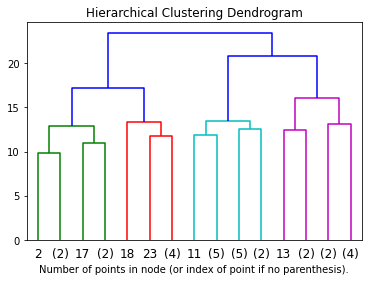

In [ ]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = bert_encoded_input[2]

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

